# Análisis inicial de Redes usando protocolo ICMP

## Introducción

<p>Se desea conocer los caminos más comunes que recorren los paquetes de datos entre la casa ecuatoriana promedio y ciertos sitios web de alto tráfico y uso común. Esta información, geolocalizada, permite una mejor comprensión de cómo la información cruza grandes distancias a través de la capa física del modelo de conexión actual. Como es claro, estos paquetes tienen que atravesar una serie de canales físicos que los llevan a su destino final, siendo los más notorios los cables submarinos a través de los cuales se envía la mayor parte de información del mundo. Por supuesto, este experimento sólo es tán válido como lo son la calidad de sus datos, por lo cual su funcionalidad se ve, de cierta manera, limitada.<p>

Los datos que se usan en este experimento fueron recaudados en una etapa previa del proyecto. Se recolectaron tres datos (idealmente, en tiempos distintos del día) por participante del proyecto, con un total de 22 participantes. En total, se recolectaron 66 documentos por sitio web que describieran el camino que se empleó para llegar desde sus domicilios hasta las páginas correspondientes. A pesar de que los participantes tienen situaciones de alojamiento y conexiones variadas, es también importante aclarar que todos los estudiantes viven en Quito, se encuentran entre los 20 y los 25 años, y todos son estudiantes a tiempo completo de una universidad privada de Ecuador, por lo que los datos pueden estar sujetos a situaciones similares. Sin embargo, la variación general que existe entre los estudiantes es suficiente para, aunque sea *a grosso modo*, crear una imagen general del tráfico de internet de Quito a los sitios web investigados.


## Metodología

Para la implementación de este experimento, se trabajó en lenguaje Python, haciendo uso de las bibliotecas ya disponibles para graficar las redes creadas, además de determinar el camino más común y averiguar más información de este. Se basó el código, además, en la implementación ya existente de Daniel Riofrío, PhD, para graficar la red general de todos los documentos de la investigación previa. Se continuó con los siguientes pasos:

1. Se determinó los sitios web a analizar para el proyecto.
  * Las direcciones web a analizar son:
    * Google.com
    * Facebook.com
  * A pesar de que esta elección fue al azar, estos sitios son ideales ya que por su alto tráfico y posición pública, los paquetes suelen llegar de manera confiable y rápida
2. Se separaron los archivos de interés del repertorio de archivos disponibles
  * El repertorio cuenta con 66 archivos para 22 sitios web de uso cotidiano distintos
  * Para los ejemplos en el informe, se utiliza la separación de Google.com
3. Se almacenó la información de cada una de las direcciones IP exploradas en estos caminos, además de las veces que cada conexión entre dos IP específicas fue utilizada, en una estructura de grafo
  * Se filtran los datos que se consideran de una red LAN, y se los reemplaza con la dirección general "127.0.0.1"
  * Se invierte los pesos del grafo, de tal manera que los caminos más transitados sean los más baratos
4. Se encuentra la ruta más usada entre el punto de inicio y el punto de llegada
  * Debido a que existen varios puntos de llegada, se analiza la ruta más usada a cada uno
  * Se grafica, además, las rutas más usadas de cada punto
5. Del punto de llegada más común, se analiza la información de cada nodo
  * Se analiza la información de ANS y la información de Geolocalización
  * En caso de que un IP sea privado, se informe de tal

Una vez obtenida toda esta información, se procede a analizar los resultados del experimento.

Se declaran los módulos a utilizar.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import os
import ip2geotools.databases.noncommercial as dbs
import pandas as pd
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from ipwhois import IPWhois
from pprint import pprint

%matplotlib inline

Se declaran las variables y contenedores de datos iniciales.

In [2]:
site_name = 'Google'
start_ip = '127.0.0.1'

#Path de lectura de archivos generados con traceroute.py
path = './All'

#lista todos los archivos dentro de la carpeta definida en path
files = os.listdir(path)

#diccionario que guarda los edges y sus frecuencias/pesos de los caminos mas comunes.
edge_dict = {}

#Grafo dirigido que tendra todas las rutas que siguieron los paquetes.
G = nx.DiGraph()

#contado de ips filtradas
filtered_counter = 0

Se leen los archivos dentro del directorio ``\All``. Cada archivo está estructurado de la forma:
* IP destino
* 1    IP
* 2    IP
...
* n    IP/Sitio Destino

y se arma el diccionario de edges con todas las secuencias de IPs en los archivos.

In [3]:
#forloop usado para leer todos los archivos listados en el path.
for file_name in files:

    file_name_pieces = file_name.split('.')
    
    #Saltamos este archivo si no corresponde al IP estudiado
    if site_name not in file_name_pieces[1]: 
        continue
    
    fd =  open(path+'/'+file_name, 'r')
    file = fd.read()
    file_split = file.split('\n')
    len_file_split = len(file_split)

    destination = ''
    prev = ''

    #ips que vamos a filtrar de los tres primeros registros de cada archivo que vamos a analizar.
    #¿qué son estos ips?
    filter_ip = ['192.168.100.1', '192.168.10.1', '192.168.1.1',
                 '10.0.2.2', '192.168.0.1','172.21.140.1','192.168.4.1',
                 '192.168.0.254', '192.168.10.1', '192.168.1.10']

    #ip de destino que se encuentra en la primera linea del archivo generado por traceroute.py
    destination = file_split[0].rstrip('\r')

    #forloop para iterar todas las entradas del archivo generado por traceroute.py desde el primer registro del tipo 1-IP.
    for i in range(1, len_file_split-1):
        split_line = file_split[i].split('\t')
        curr = split_line[1]
        curr = curr.rstrip('\r')

        #filtrado de cualquier current ip que no sea una ip valida.
        if curr != '*':

            #filtrado de aquellas ips en filter_ip que esten en las primeras tres lineas del archivo.
            if (i == 1 or i == 2 or i == 3) and (curr in filter_ip):
                filtered_counter = filtered_counter + 1
            else:
                #agrega los edges al diccionario que llevan al destino
                if curr == destination and prev != '':
                    edge = (prev, destination.rstrip('\r') + '/' + file_name_pieces[1])
                    if edge in edge_dict:
                        edge_dict[edge] = edge_dict[edge] + 1
                    else:
                        edge_dict[edge] = 1
                else:
                    #agrega los edges de aquellos edges que no llevan a destino
                    #en el if / positivo -> agrega toda ip seguida de otra ip en el camino del traceroute.
                    if prev != '':
                        edge = (prev, curr)
                        if edge in edge_dict:
                            edge_dict[edge] = edge_dict[edge] + 1
                        else:
                            edge_dict[edge] = 1
                    else:
                        #agrega el nodo especial que vamos a llamar 127.0.0.1 desde el cual vamos a buscar el camino mas corto.
                        if curr != destination and prev == '':
                            edge = (start_ip, curr)
                            if not edge in edge_dict:
                                edge_dict[edge] = 0
                    prev = curr

# Código por Daniel Riofrío (2020)

Se estructuran los edges de ``edge_dict`` en un grafo ``G``. Luego, se grafica el grafo completo.

Nodes of graph: 
198
Edges of graph: 
361
Filtered IPs: 65
{'172.21.18.126': {'weight': 0}, '181.198.150.1': {'weight': 0}, '172.20.10.1': {'weight': 0}, '192.168.86.1': {'weight': 0}, '200.63.218.101': {'weight': 0}, '100.98.8.1': {'weight': 0}, '181.198.130.1': {'weight': 0}, '74.125.202.106': {'weight': 0}, '172.253.66.57': {'weight': 0}, '172.253.50.89': {'weight': 0}, '186.4.244.1': {'weight': 0}, '100.97.32.1': {'weight': 0}, '157.100.244.1': {'weight': 0}, '10.0.0.1': {'weight': 0}, '186.46.4.225': {'weight': 0}, '186.46.4.173': {'weight': 0}, '186.101.152.1': {'weight': 0}, '186.4.145.1': {'weight': 0}, '100.96.233.1': {'weight': 0}, '200.63.218.185': {'weight': 0}, '100.98.68.1': {'weight': 0}, '186.101.137.1': {'weight': 0}, '181.198.191.129': {'weight': 0}, '186.46.4.226': {'weight': 0}, '186.46.4.174': {'weight': 0}}


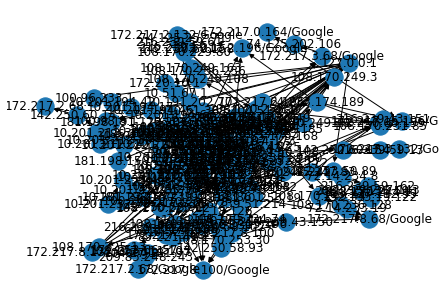

In [4]:
#Se agregan todos los edges y nodos al grafo
for key, value in edge_dict.items():
    if value == 0:
        G.add_edge(key[0], key[1], weight=0)
    else:
        G.add_edge(key[0], key[1], weight=(1.0/float(value)))

#se imprime el total de nodos del grafo.
print("Nodes of graph: ")
print(len(G.nodes()))
#se imprime el total de edges del grafo.
print("Edges of graph: ")
print(len(G.edges()))
#se imprime el total de nodos filtrados.
print ("Filtered IPs: " + str(filtered_counter))
#se imprimen todos los nodos que estan conectados al nodo especial 127.0.0.1
print (G['127.0.0.1'])

#se dibuja el grafo.
nx.draw(G, with_labels=True)
#nx.draw_circular(G, with_labels=True)
plt.show()

# Código por Daniel Riofrío (2020)

Se identifican todos los nodos finales del grafo (todos los nodos que terminan en ``/Google``)

In [5]:
endpoints = {}

for e, w in edge_dict.items():
    if site_name in e[1]: 
        try:
            endpoints[e[1]] += w
        except:
            endpoints[e[1]] = w
            
most_used_endpoint = max(endpoints.items())            

print("Existen "+ str(len(endpoints)) + " IPs destino para " + site_name + "\n")
print("El endpoint más usado es :\n", most_used_endpoint)

Existen 10 IPs destino para Google

El endpoint más usado es :
 ('172.217.8.68/Google', 4)


Se busca en todos los edges el nodo de inicio ``127.0.0.1`` y se identifican todos los nodos que lo suceden. Se guardan estos IPs como ``startpoints``.

In [6]:
startpoints = []
_startpoints = {}

for e, w in edge_dict.items():
    if start_ip in e[0]: 
        startpoints.append(e[1])

for sp in startpoints:
    for e, w in edge_dict.items():
        if sp in e[0]:
            if e[0] not in _startpoints.keys():
                _startpoints[e[0]] = w
            else:
                _startpoints[e[0]] += w
    
print("Existen "+ str(len(_startpoints)) + " IPs que suceden al IP de inicio: " + start_ip + '\n')
total = 0
for sp, w in _startpoints.items():
    total += w
    
print(f"{str(total)} Total pesos de edges que proceden del edge con IP inicial ({start_ip}).\n")
print(f"Este número es mayor al número de archivos de {site_name} porque no todos estos edges (_startpoints) proceden del edge con IP inicial {start_ip}")

Existen 25 IPs que suceden al IP de inicio: 127.0.0.1

117 Total pesos de edges que proceden del edge con IP inicial (127.0.0.1).

Este número es mayor al número de archivos de Google porque no todos estos edges (_startpoints) proceden del edge con IP inicial 127.0.0.1


### Shortest Path
Para encontrar el camino más usado en el grafo usamos el algoritmo de ``shortest_path`` que viene con ``networkx``. Este algoritmo construye un camino de un nodo inicial a uno final siguiendo los edges con menores pesos posibles. Cabe recordar que en el código anterior, al crear el Grafo e insertar los edges, los pesos son inversamente proporcionales a las veces que un edge fue atravesado. Esto permite considerar la ruta que devuelve este algoritmo como el camino más usado para llegar al nodo destino.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)


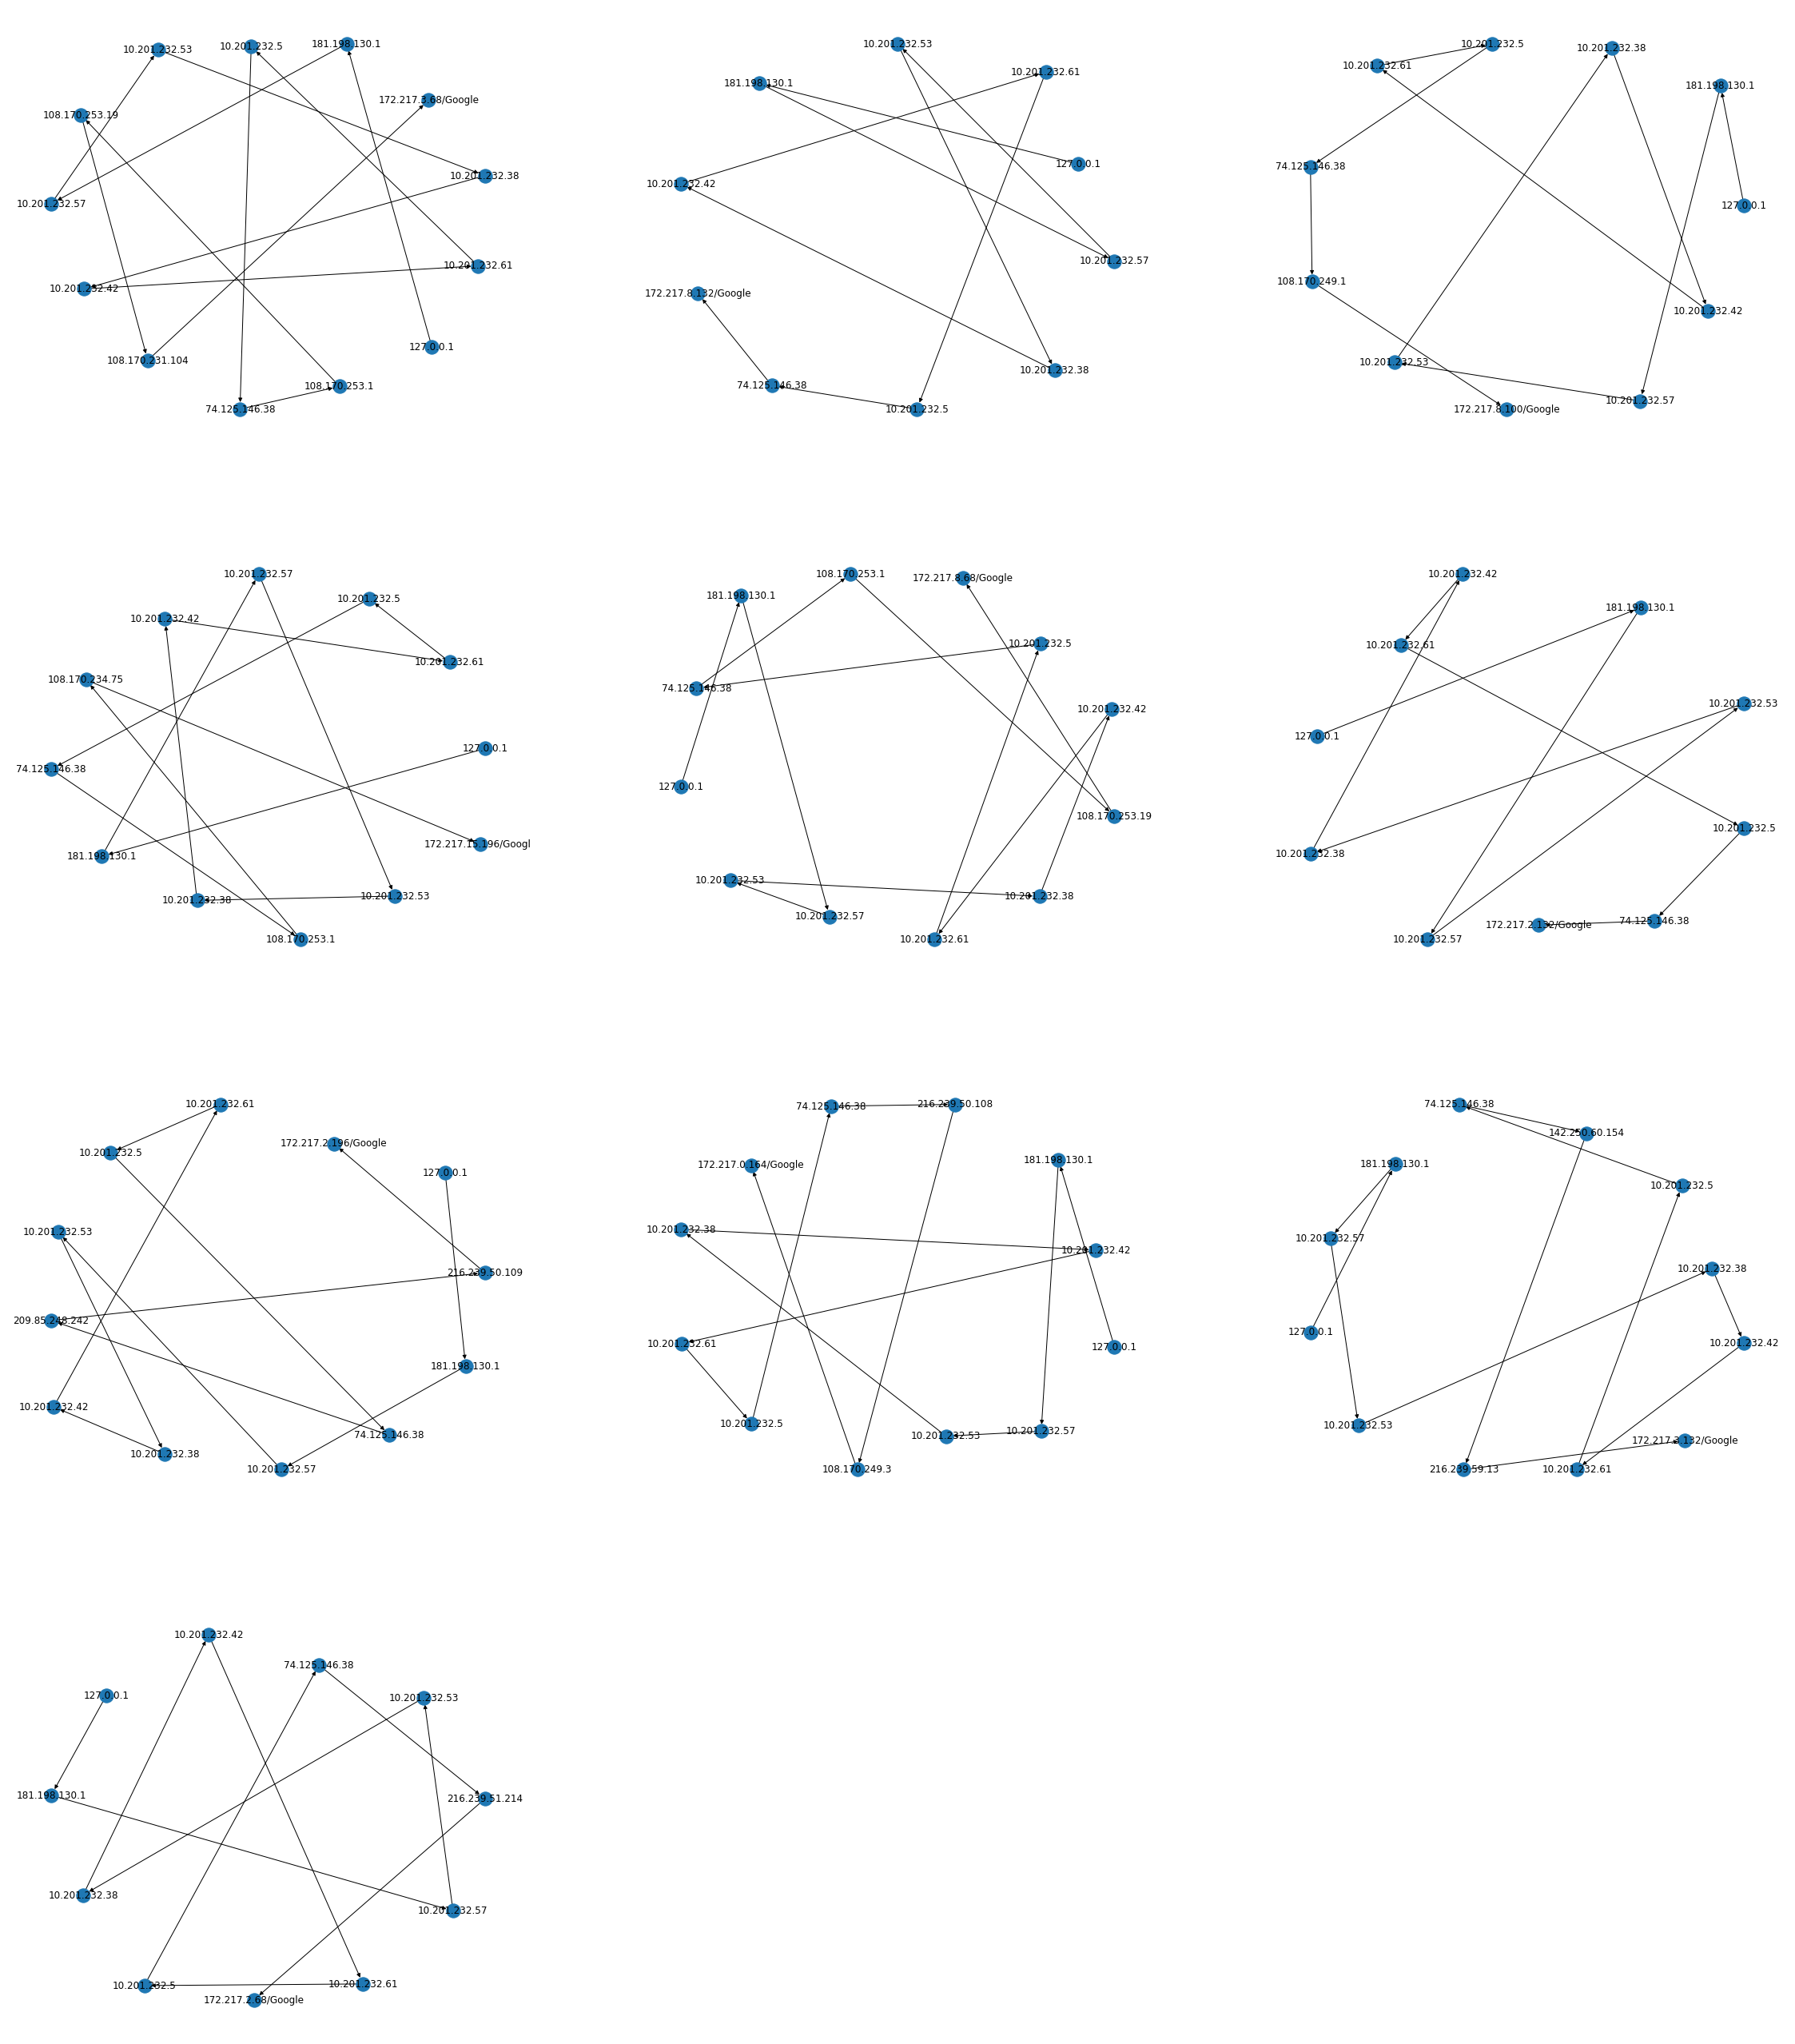

In [7]:
shortest_paths = []
plt.figure(figsize=(40, 120))
j = 0

# Para cada endpoint se busca su camino más corto en el grafo y se grafica.
for ep, times_used in endpoints.items():
    j += 1
    sp = nx.algorithms.shortest_path(G, source=start_ip , target=ep, weight='weight')
    shortest_paths.append(sp)
    sp_G = nx.DiGraph()

    for i in range(len(sp)):
        try:
            sp_G.add_edge(sp[i], sp[i+1], weight=0)
        except:
            
            plt.subplot(10,3, j)
            
            #se dibuja el grafo.
            nx.draw(sp_G, with_labels=True)
            plt.xlabel(f"Endpoint:\t{ep}\nPath length:\t{len(sp)}\nTimes used:\t{times_used}")
            
plt.show()

# TODO: Mateo
Explicar este código y whois en general

In [14]:
print("Informacion WHOIS de cada nodo del camino\n")

sp = nx.algorithms.shortest_path(G, source=start_ip , target=max(endpoints), weight='weight')

for i in range(len(sp)-1):
    ip = sp[i]
    print(ip+'\n')
    try:
        obj = IPWhois(ip)
        result = obj.lookup_rdap(asn_methods=['dns', 'whois', 'http'])
        print(f"\tASN: {result['asn']}",f"\tCIDR: {result['asn_cidr']}",
              f"\tCodigo de pais: {result['asn_country_code']}",
              f"\tDescripcion: {result['asn_description']}",
              f"\tRegistrado en: {result['asn_registry']}\n",sep='\n')
    except:
        print("\tINFORMACION PRIVADA\n")

ep = sp[-1]
ep_ip = ep.split('/')[0]
print(ep_ip+'\n')
try:
    obj = IPWhois(ep_ip)
    result = obj.lookup_rdap(asn_methods=['dns', 'whois', 'http'])
    print(f"\tASN: {result['asn']}",f"\tCIDR: {result['asn_cidr']}",
              f"\tCodigo de pais: {result['asn_country_code']}",
              f"\tDescripcion: {result['asn_description']}",
              f"\tRegistrado en: {result['asn_registry']}\n",sep='\n')
except:
    print("\tINFORMACION PRIVADA\n")

Informacion WHOIS de cada nodo del camino

127.0.0.1

	INFORMACION PRIVADA

181.198.130.1

	ASN: 27947
	CIDR: 181.198.128.0/19
	Codigo de pais: EC
	Descripcion: Telconet S.A, EC
	Registrado en: lacnic

10.201.232.57

	INFORMACION PRIVADA

10.201.232.53

	INFORMACION PRIVADA

10.201.232.38

	INFORMACION PRIVADA

10.201.232.42

	INFORMACION PRIVADA

10.201.232.61

	INFORMACION PRIVADA

10.201.232.5

	INFORMACION PRIVADA

74.125.146.38

	ASN: 15169
	CIDR: 74.125.0.0/16
	Codigo de pais: US
	Descripcion: GOOGLE, US
	Registrado en: arin

108.170.253.1

	ASN: 15169
	CIDR: 108.170.192.0/18
	Codigo de pais: US
	Descripcion: GOOGLE, US
	Registrado en: arin

108.170.253.19

	ASN: 15169
	CIDR: 108.170.192.0/18
	Codigo de pais: US
	Descripcion: GOOGLE, US
	Registrado en: arin

172.217.8.68

	ASN: 15169
	CIDR: 172.217.8.0/24
	Codigo de pais: US
	Descripcion: GOOGLE, US
	Registrado en: arin



# TODO
Explicar ip2geotools e implementar impresión en mapa 

In [12]:
most_used_path = nx.algorithms.shortest_path(G, source=start_ip , target=max(endpoints), weight='weight')

coordinates = []
just_countries = []


for ip in most_used_path:
    ip = ip.split('/')[0]
    r = dbs.HostIP.get(ip)
    if not r.country and not r.region and not r.city and not r.longitude and not r.latitude:
        print(ip, "Private", sep='\t')
    else:
        if r.longitude and r.latitude: coordinates.append((r.longitude, r.latitude))
        elif r.country: just_countries.append(r.country)
            
        print(f"\n{ip}\nCtry:\t{r.country if r.country else ''}\nCity:\t{r.city if r.city else ''}\nRegn:\t{r.region if r.region else ''}\nLong:\t{r.longitude if r.longitude else ''}\nLat:\t{r.latitude if r.latitude else ''}\n")

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


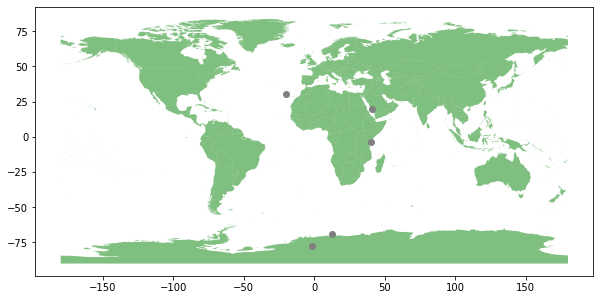

In [64]:
map = gpd.read_file('TM_WORLD_BORDERS-0.3.shp')

geometry = [Point(xy) for xy in coordinates]

geo_df_exact = gpd.GeoDataFrame(geometry= geometry)


country_df = pd.read_csv('countries_codes_and_coordinates.csv')

country_df = country_df.set_index('alpha-2')
_df = country_df.loc[just_countries]

just_c_coords = [xy for xy in zip([x[1] for x in _df['latitude'].items()], [x[1] for x in _df['longitude'].items()])]


fig, ax = plt.subplots(figsize=(10, 10))

map.plot(ax=ax, alpha=0.5, color='green');
geo_df_exact.plot(ax=ax, color='red');

geometry = [Point(xy) for xy in just_c_coords]
geo_df_just_c = gpd.GeoDataFrame(geometry= geometry)
geo_df_just_c.plot(ax=ax, color='gray');

## Conclusiones
# TODO

* ¿Por dónde pasan las comunicaciones que salen del país? 
* ¿Cuántas personas usan un mismo servicio de internet en clase?
* ¿Es seguro que estemos haciendo este tipo de mediciones desde casa? 
* ¿Qué pasa si corremos este tipo de monitoreo todos los días, todos los minutos?